In [4]:

import tensorflow as tf
print(tf.__version__)

2.18.0


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [6]:
# 1. Set data directory and clean invalid images
data_dir = 'Dataset'

for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        try:
            img = cv2.imread(image_path)
            if img is None:  # If image can't be read
                print(f"Removing invalid image: {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"Error with image: {image_path}")


In [7]:
# 2. Load dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32
)

# ✅ Save class names before mapping
class_names = data.class_names
print("Class names:", class_names)

Found 598 files belonging to 2 classes.
Class names: ['Healthy', 'Unhealthy']
Class names: ['Healthy', 'Unhealthy']


In [8]:
# 3. Normalize images
data = data.map(lambda x, y: (x / 255.0, y))

In [9]:
# 4. Split into train, validation, test
data_size = len(data)
train_size = int(0.7 * data_size)
val_size = int(0.2 * data_size)
test_size = data_size - train_size - val_size

train_ds = data.take(train_size)
val_ds = data.skip(train_size).take(val_size)
test_ds = data.skip(train_size + val_size).take(test_size)

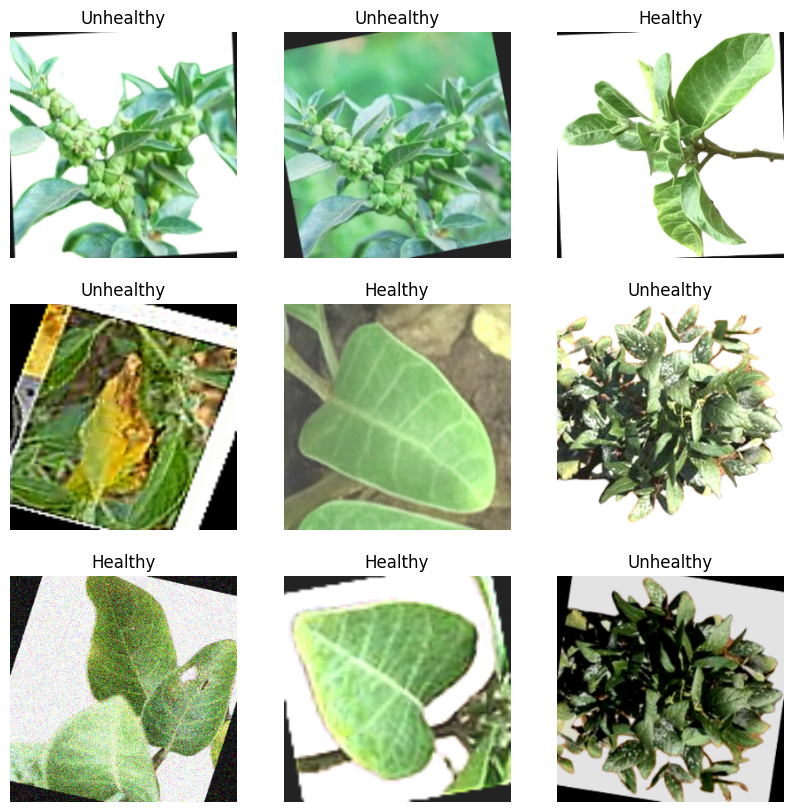

In [10]:
# 5. Visualize sample images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])  # Fixed
        plt.axis("off")
    plt.show()

In [11]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import Model

# 6. Load Pretrained Model (InceptionResNetV2)
base_model = InceptionResNetV2(
    include_top=False,   # exclude final ImageNet classification layer
    weights="imagenet",  # use pretrained weights
    input_shape=(256, 256, 3)
)

# Freeze base model layers (so pretrained features are not destroyed initially)
base_model.trainable = False

# Add custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)   # reduce features
x = layers.Dense(256, activation="relu")(x)              # dense layer
x = layers.Dropout(0.3)(x)                               # regularization
output = layers.Dense(len(class_names), activation="softmax")(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [ ]:
# 7. Compile Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 8. Train Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # you can increase later
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.5653 - loss: 0.8914 - val_accuracy: 0.8958 - val_loss: 0.3094
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.5653 - loss: 0.8914 - val_accuracy: 0.8958 - val_loss: 0.3094
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.8481 - loss: 0.3247 - val_accuracy: 0.9375 - val_loss: 0.1578
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.8481 - loss: 0.3247 - val_accuracy: 0.9375 - val_loss: 0.1578
Epoch 3/10
 8/13 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9320 - loss: 0.1794

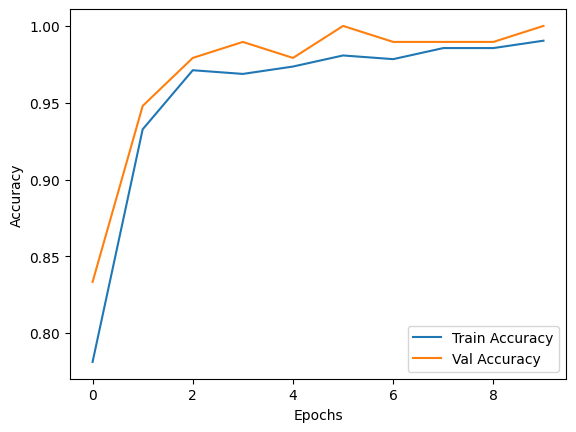

In [ ]:
# 9. Plot Training History
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

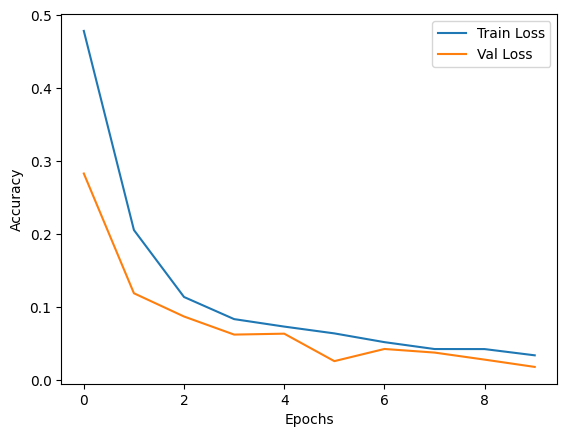

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 10. Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 0.0162
Test Accuracy: 1.00


In [ ]:
# 12. Prediction Function
def predict_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not read image from {img_path}")
        return None
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    confidence = np.max(pred)
    return class_names[class_idx], confidence

In [ ]:
# Test prediction with a valid image file
result = predict_image('Dataset/Healthy/leaf_0.png')
if result:
    predicted_class, confidence = result
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
else:
    print("Prediction failed")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class: Healthy
Confidence: 1.0000
Predicted class: Healthy
Confidence: 1.0000


In [ ]:
# Test prediction with an unhealthy image
result_unhealthy = predict_image('Dataset/Unhealthy/leaf_1.png')
if result_unhealthy:
    predicted_class, confidence = result_unhealthy
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
else:
    print("Prediction failed")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Predicted class: Unhealthy
Confidence: 0.9601
